In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import linear_model

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')
date='5/27/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]

file_name = bath_df.iat[0, 0]
file = path_name + file_name
calibration = bath_df['calibration'][120]

session = bath_df['session'][120]
cal_path = f'{session}/{calibration}'
vis_waves = get_visible_wavelength_vector(file, cal_path)
vis_columns = ["%.1f" % wave for wave in vis_waves]

low_cutoff = vis_columns.index('533.4')
high_cutoff = vis_columns.index('847.1')
print(low_cutoff, high_cutoff)

30 271


In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')

file_name = bath_df.iat[0, 0]
file = path_name + file_name
calibration = bath_df['calibration'][120]

session = bath_df['session'][120]
cal_path = f'{session}/{calibration}'
vis_waves = get_visible_wavelength_vector(file, cal_path)
vis_columns = ["%.1f" % wave for wave in vis_waves]

vis_min_index = vis_columns.index('533.4')
vis_max_index = vis_columns.index('847.1')

vis_length = vis_max_index - vis_min_index

all_absorbances = []
all_depths = []
df = pd.DataFrame()

dates = ['5/27/21', '6/4/21']

for date in dates: 
    bath_df = green_list_df.loc[green_list_df['date'] == date]
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name
    
    for index in bath_df.index.values:
        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        i_unique = bath_df['i_unique'][index]
        stop = date + " " + bath_df['target'][index][-3:]
        cal_path = f'{session}/{calibration}'
        insertion_path = f'{session}/{calibration}/{insertion}'
        vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
        vis_columns = ["%.1f" % wave for wave in vis_waves]
        insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
        insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
        insertion_df['session'] = session
        insertion_df['calibration'] = calibration
        insertion_df['insertion'] = insertion
        insertion_df['i_unique'] = i_unique
        insertion_df['stop'] = stop
        insertion_df['use'] = True
        df = pd.concat([df, insertion_df], ignore_index=True)

# to eliminate samples from above the surface
df.loc[(df.depth < 5.0),'use'] = False

# to eliminate vegetation spectra
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False

    
print(df.shape)

(1125, 248)


In [5]:
df['class'] = 1
df.loc[df['depth'] < 25, 'class'] = 2
df.loc[df['stop'] == '6/4/21 #10', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #9', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #8', 'class'] = 3
df.loc[df['stop'] == '5/27/21  #6', 'class'] = 3

In [6]:
# creates a dataframe containing only the "use" rows
df_use = df.loc[df['use']].copy()
print(df_use.shape)

(1006, 249)


In [7]:
X = df_use.iloc[:, :-8].copy()
X.shape

(1006, 241)

In [8]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([0.95419543, 0.98309974, 0.98890733, 0.98998063, 0.99046439,
       0.99083183, 0.9910655 , 0.99128159, 0.99147591, 0.99165789])

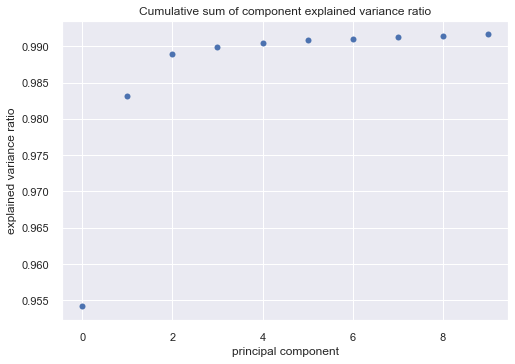

In [56]:
fig, ax = plt.subplots()
ax.set_title('Cumulative sum of component explained variance ratio')
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

In [11]:
X_pca_df = pd.DataFrame(X_pca)

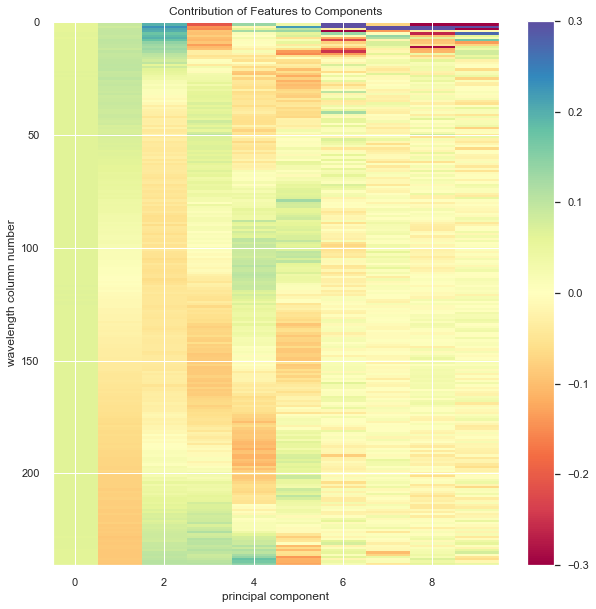

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(pca.components_[:10].T, cmap="Spectral", vmin=-0.3, vmax=0.3, aspect='auto',
          interpolation='none')
# plt.yticks(range(len(X.columns)), X.columns)
plt.title("Contribution of Features to Components")
plt.xlabel("principal component")
plt.ylabel("wavelength column number")
plt.colorbar()
plt.show()
plt.close()

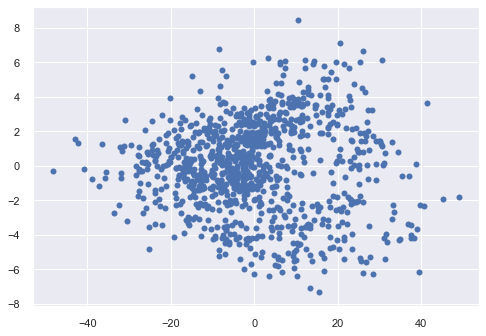

In [13]:
fig, ax = plt.subplots()
ax.plot(X_pca_df[0], X_pca_df[1], 'o')
plt.show()
plt.close()

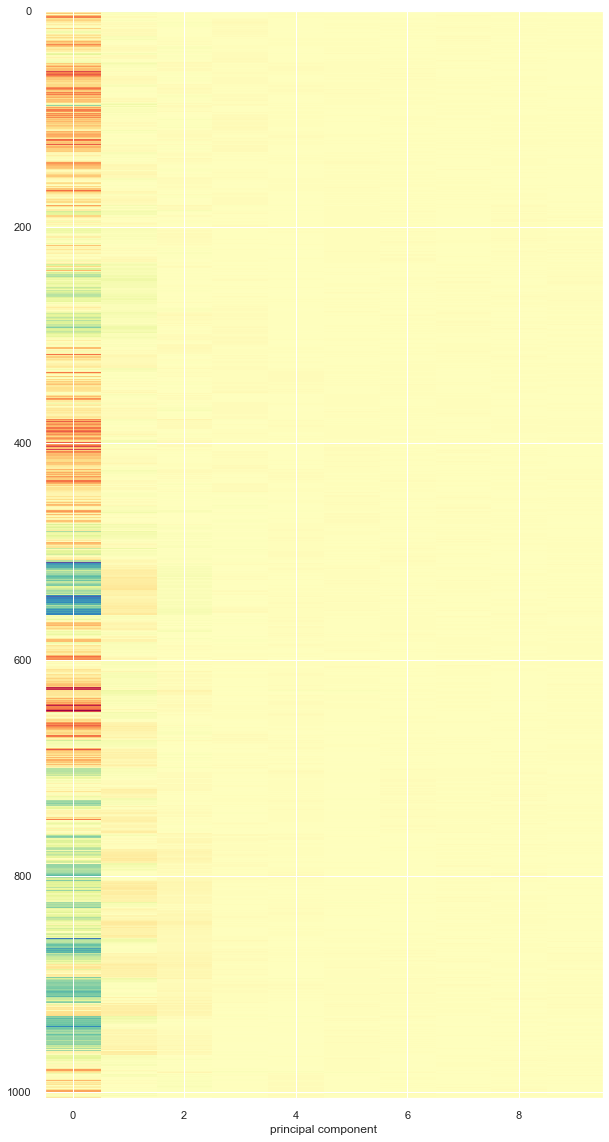

In [14]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(X_pca[:, :10], cmap="Spectral", aspect='auto',
          interpolation='none')
# plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("principal component")
plt.show()
plt.close()

In [15]:
df_info = df_use.iloc[:, -8:].copy().reset_index()

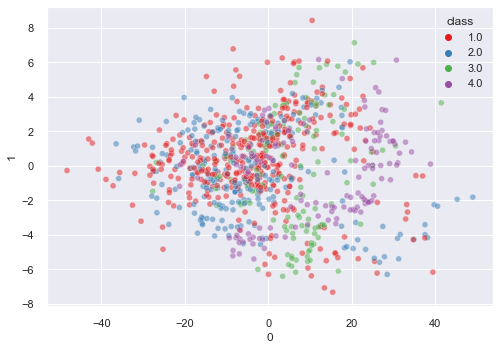

In [16]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df[0], y=X_pca_df[1], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

<AxesSubplot:xlabel='stop', ylabel='0'>

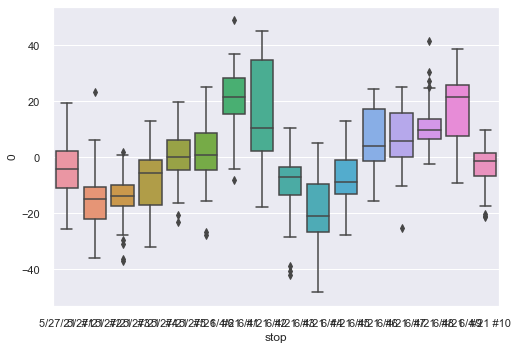

In [17]:
sns.boxplot(x=df_use['stop'], y=X_pca_df[0])

<AxesSubplot:xlabel='stop', ylabel='1'>

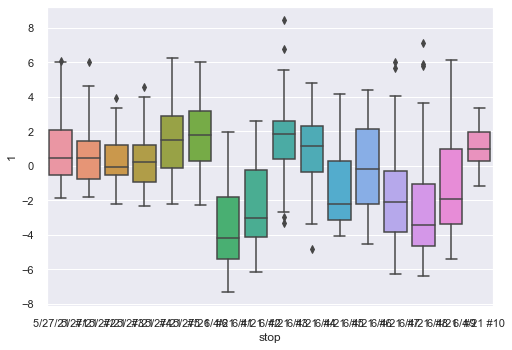

In [18]:
sns.boxplot(x=df_use['stop'], y=X_pca_df[1])

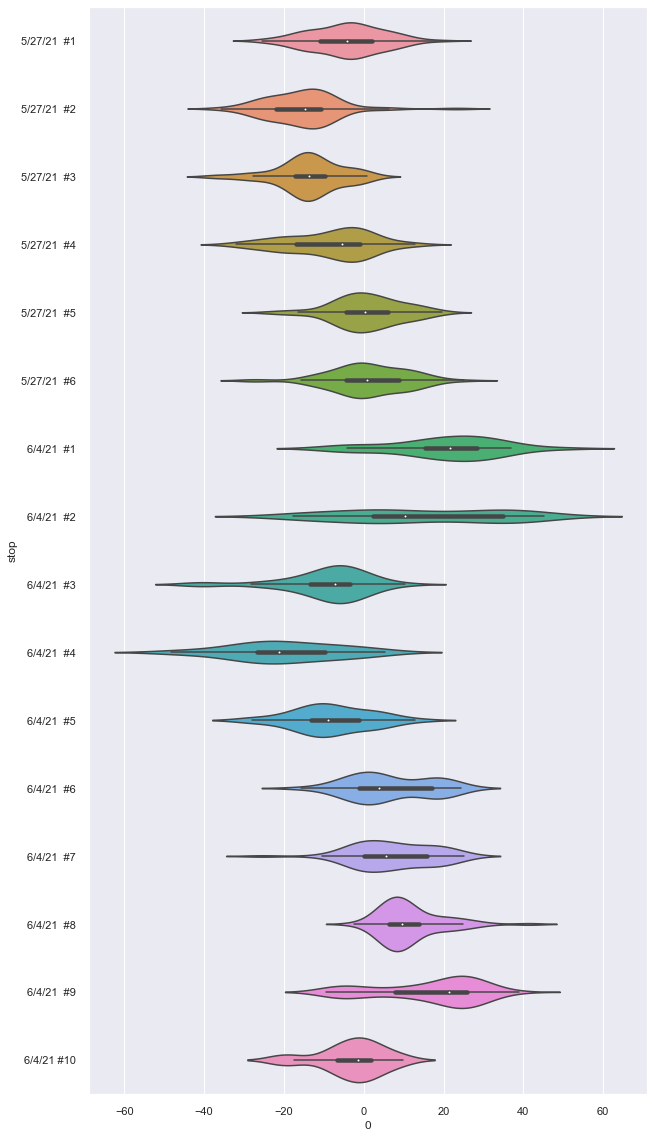

In [27]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_use['stop'], x=X_pca_df[0])
plt.show()
plt.close()

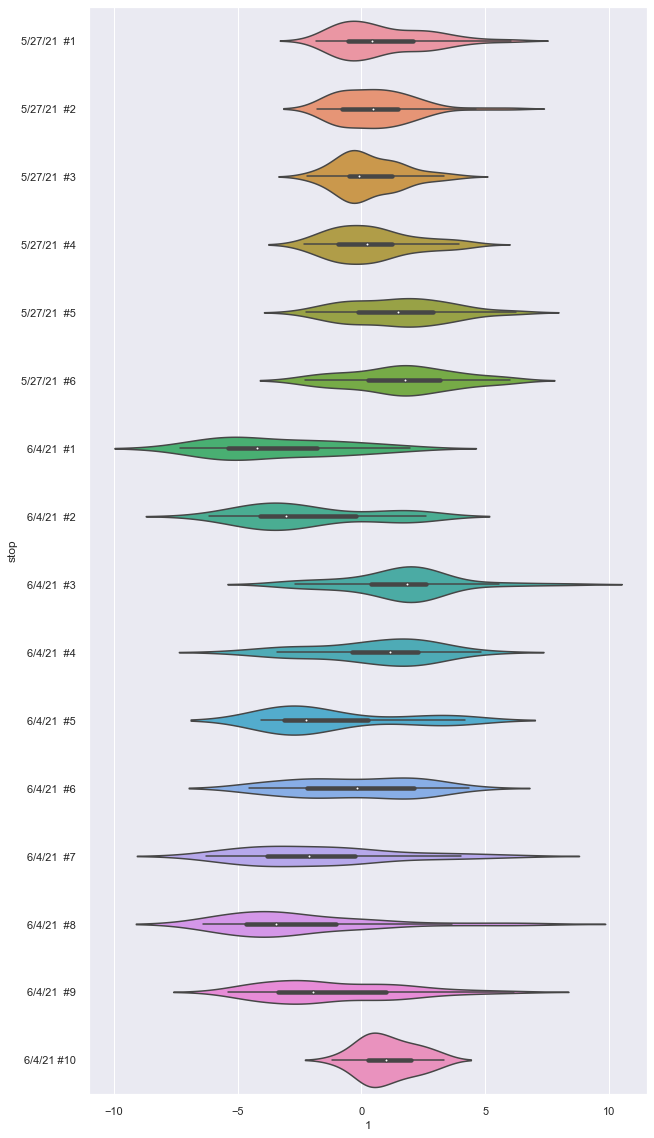

In [26]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_use['stop'], x=X_pca_df[1])
plt.show()
plt.close()

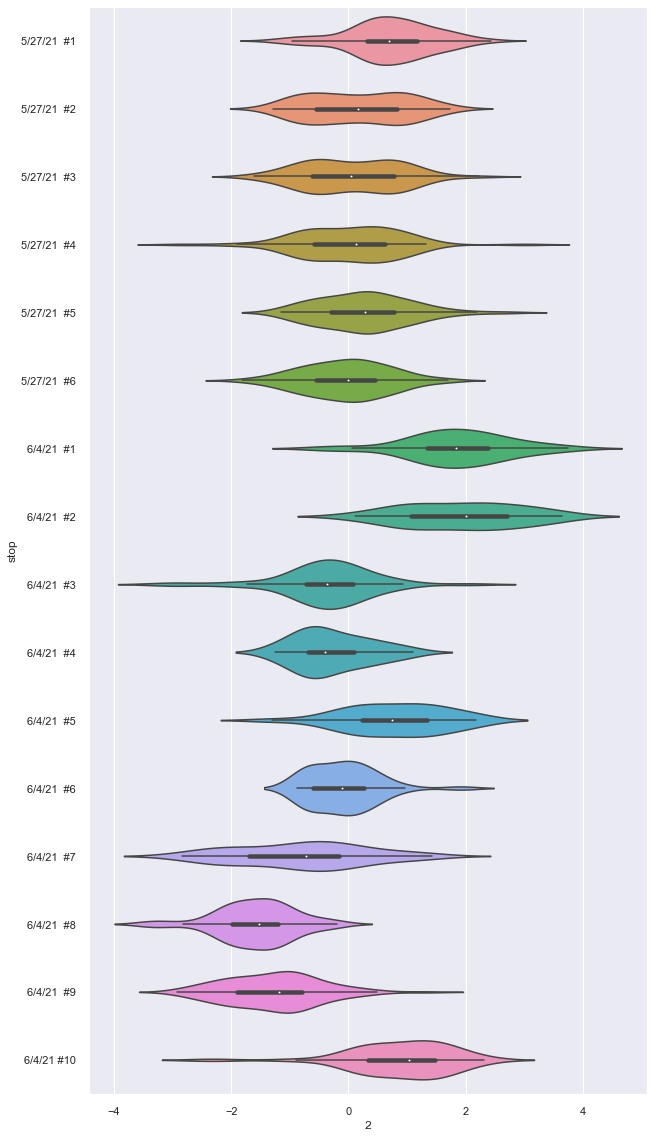

In [19]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_use['stop'], x=X_pca_df[2])
plt.show()
plt.close()

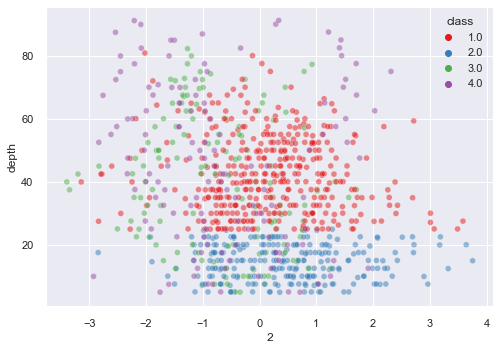

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df[2], y=df_use['depth'], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

<AxesSubplot:xlabel='2', ylabel='Density'>

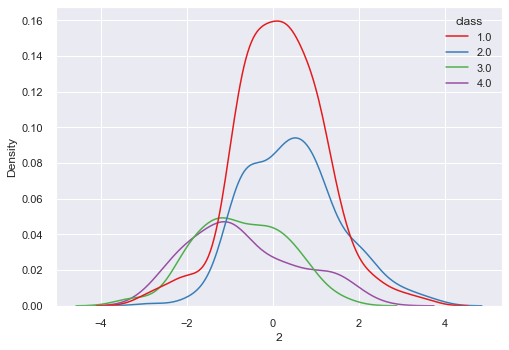

In [21]:
sns.kdeplot(x=X_pca_df[2], hue=df_use['class'], palette='Set1')

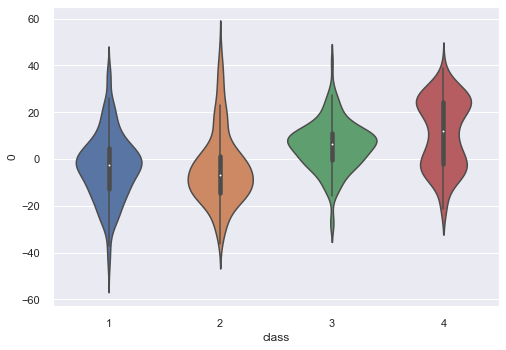

In [22]:
fig, ax = plt.subplots()
sns.violinplot(x=df_use['class'], y=X_pca_df[0])
plt.show()
plt.close()

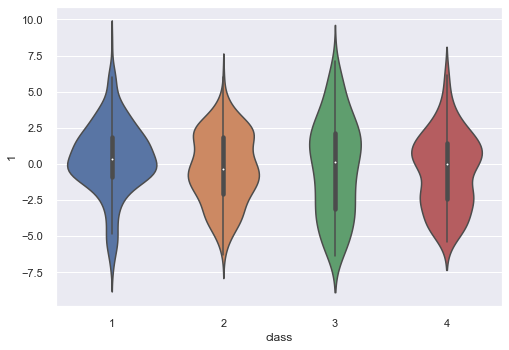

In [23]:
fig, ax = plt.subplots()
sns.violinplot(x=df_use['class'], y=X_pca_df[1])
plt.show()
plt.close()

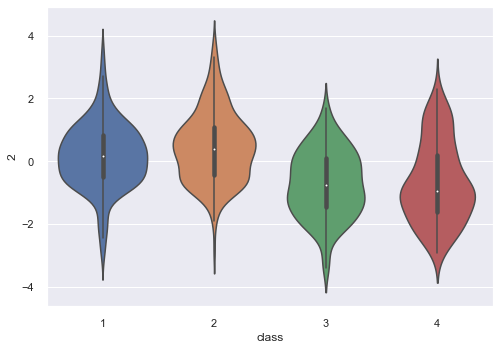

In [24]:
fig, ax = plt.subplots()
sns.violinplot(x=df_use['class'], y=X_pca_df[2])
plt.show()
plt.close()

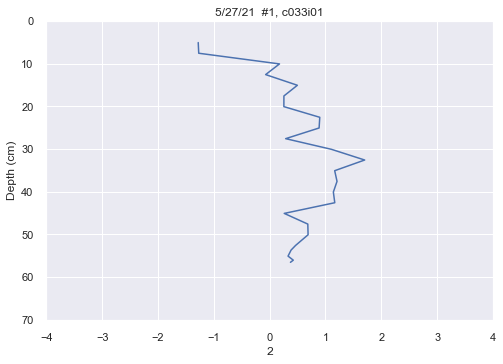

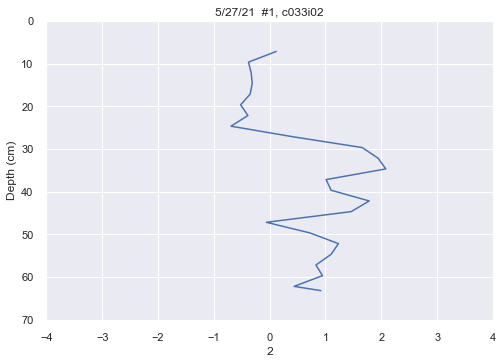

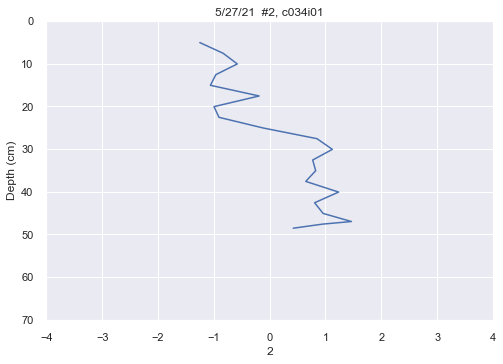

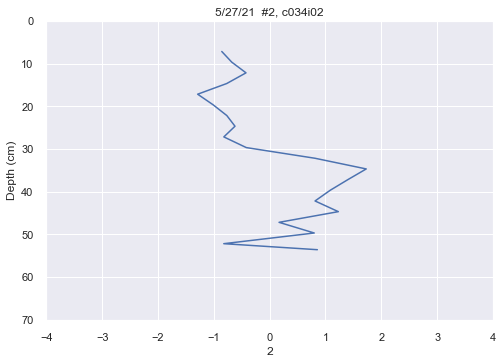

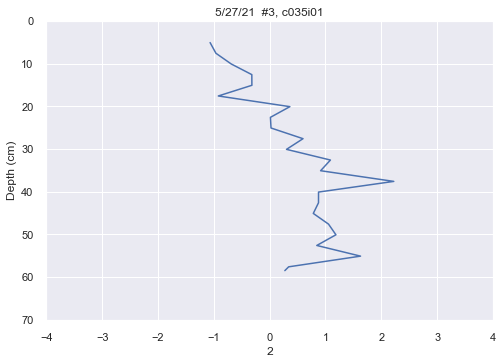

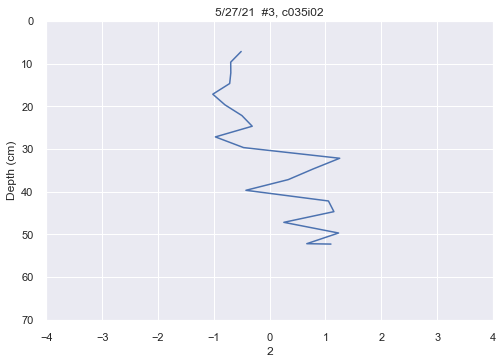

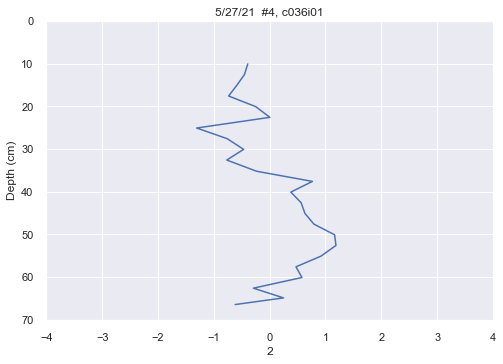

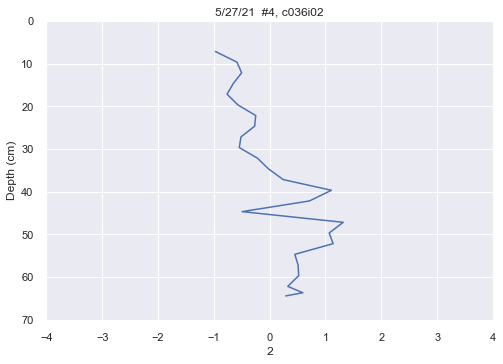

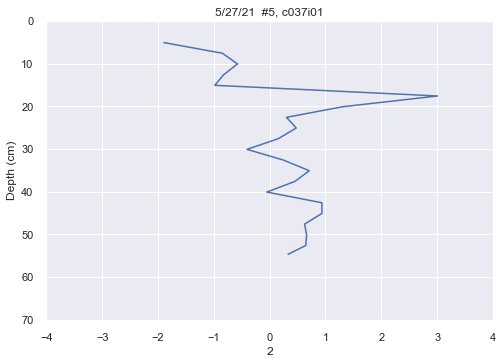

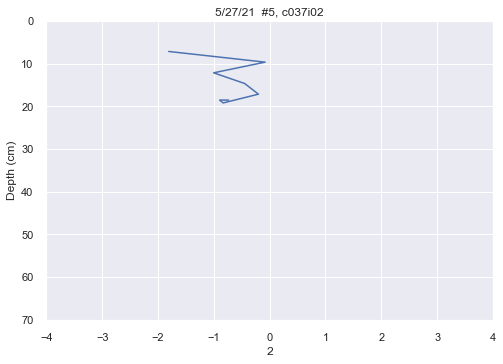

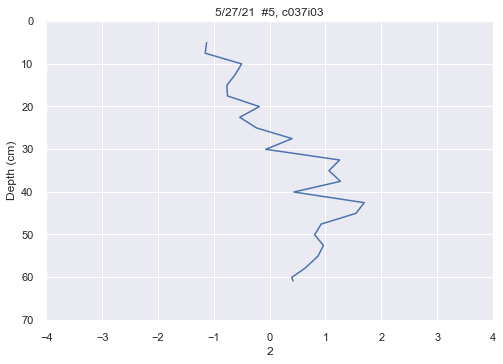

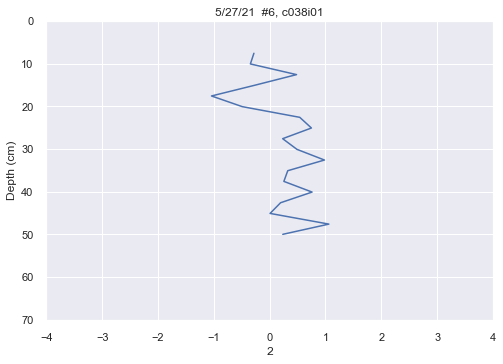

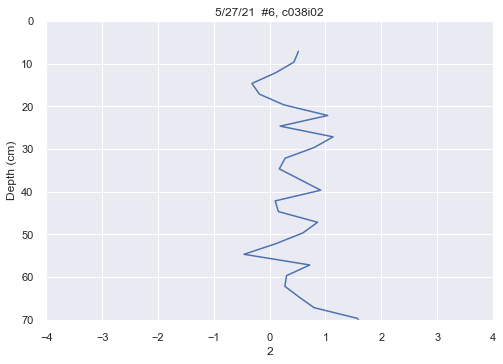

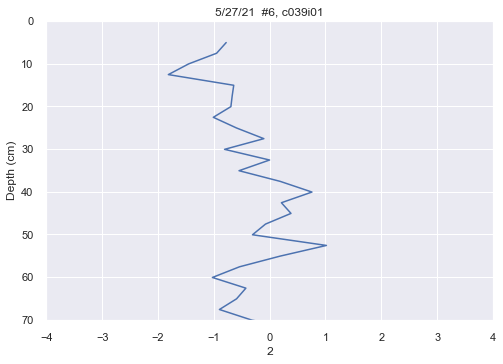

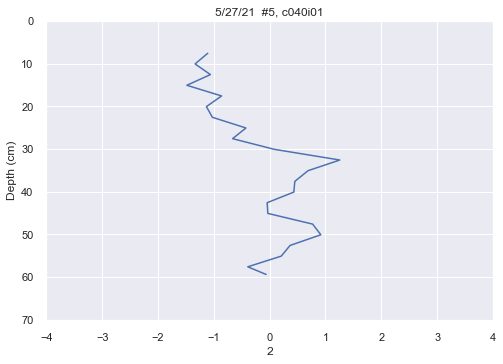

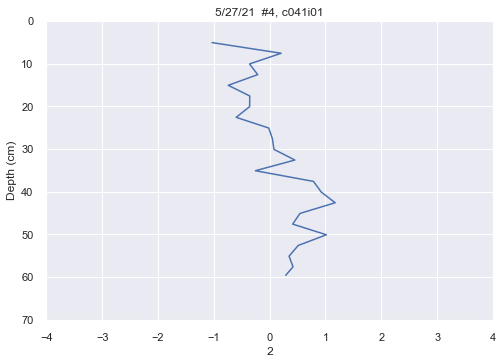

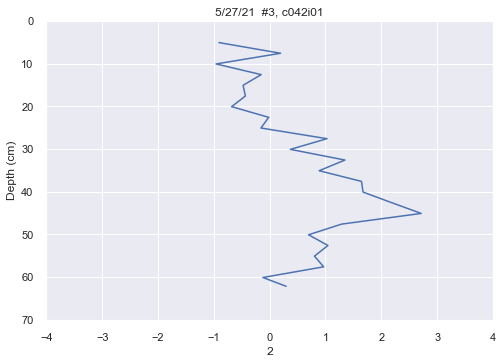

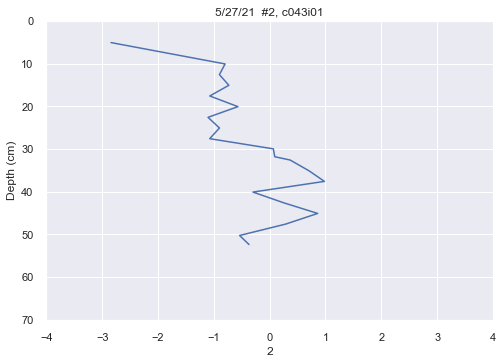

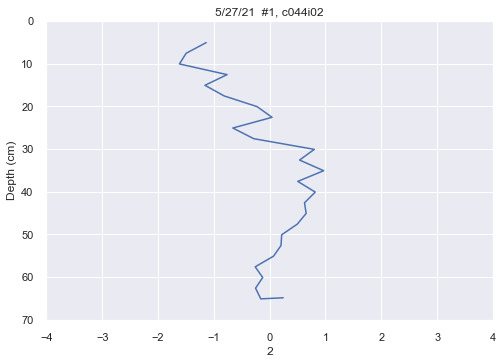

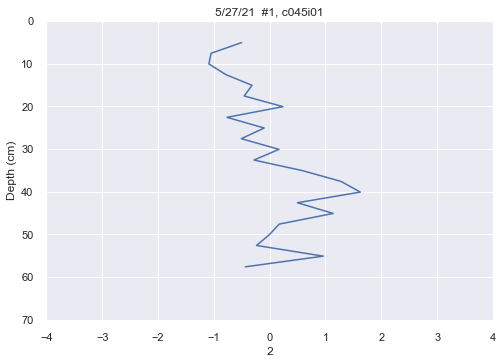

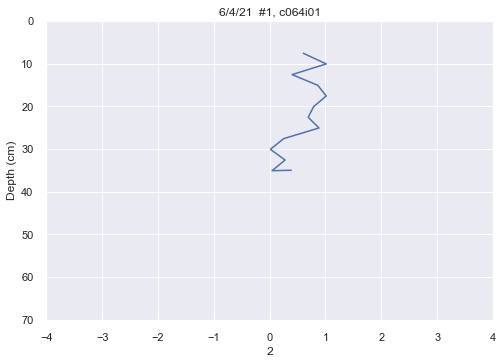

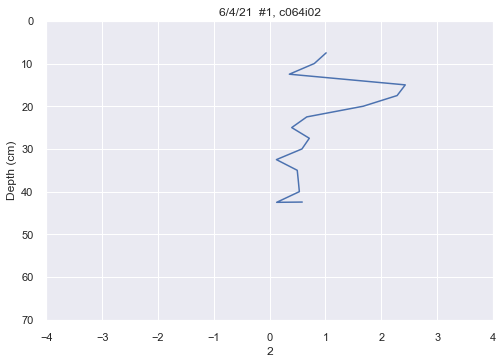

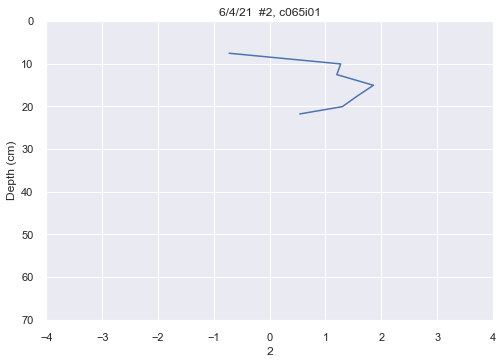

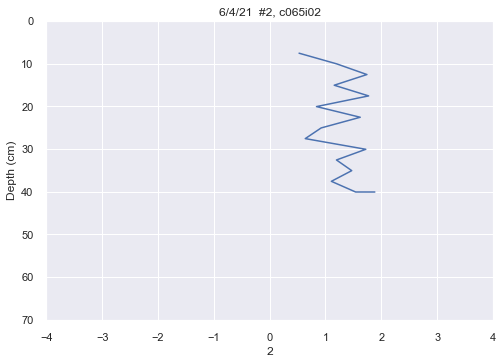

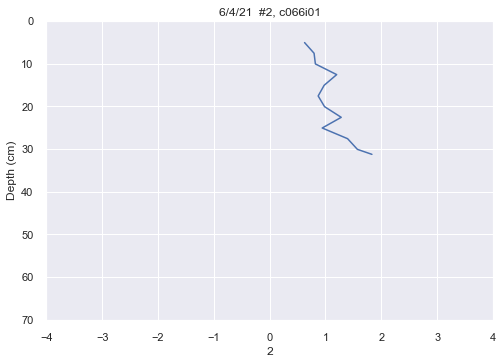

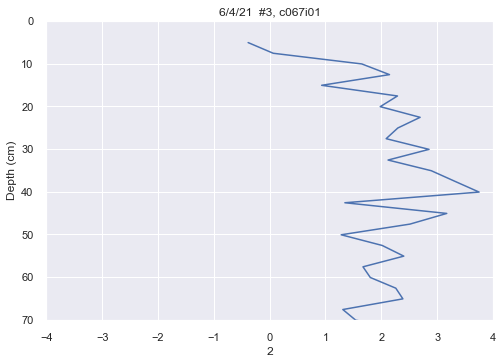

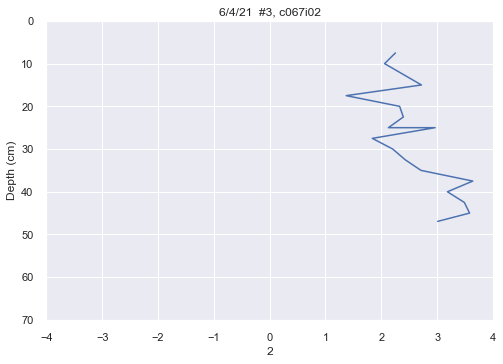

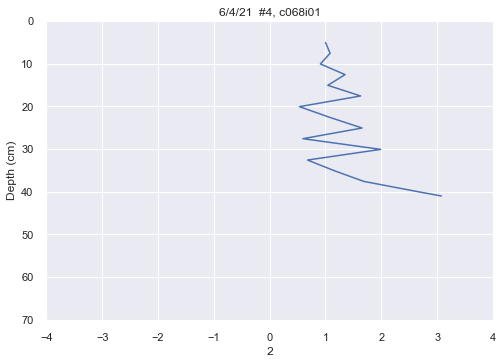

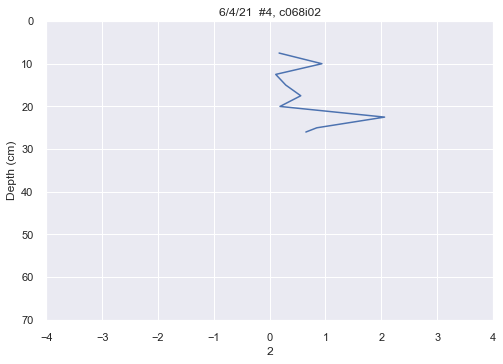

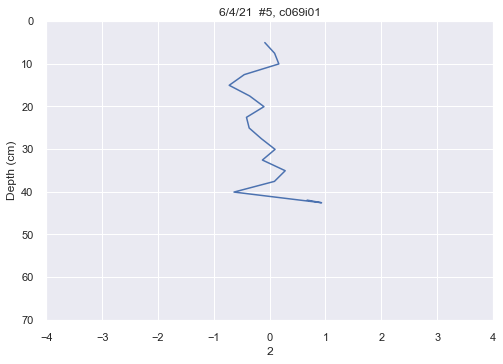

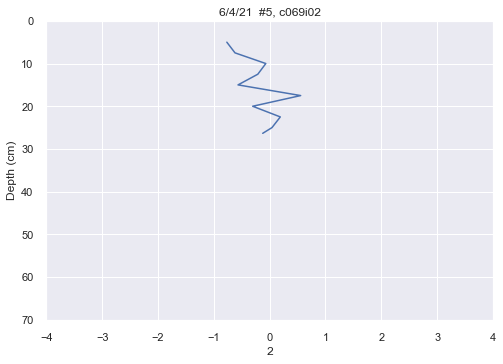

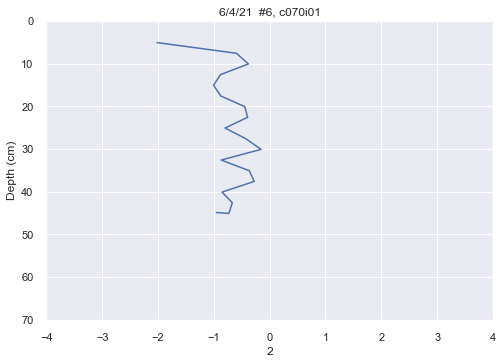

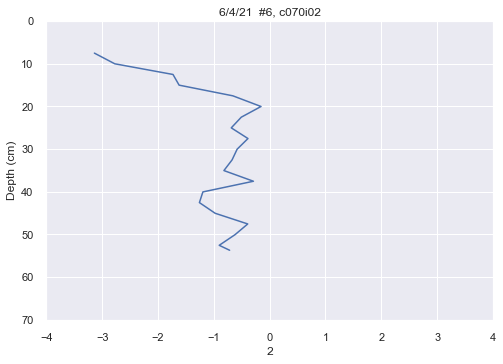

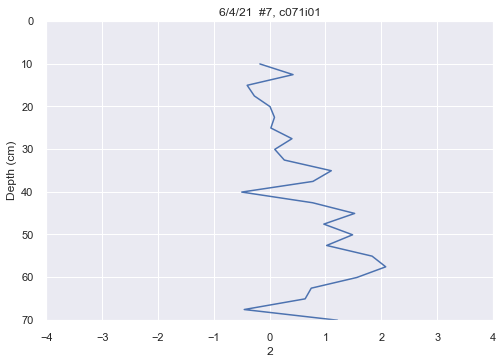

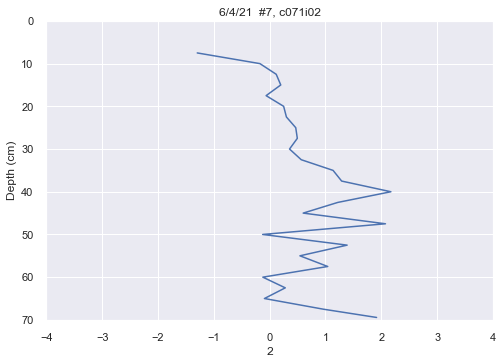

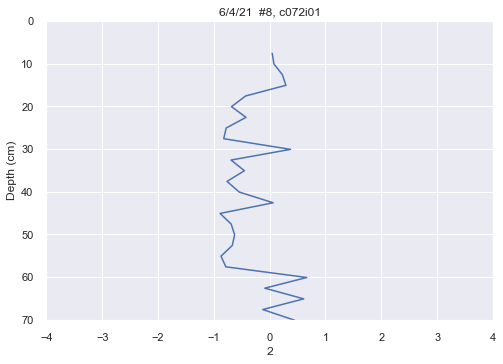

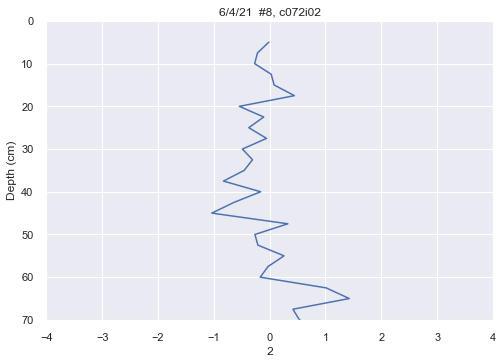

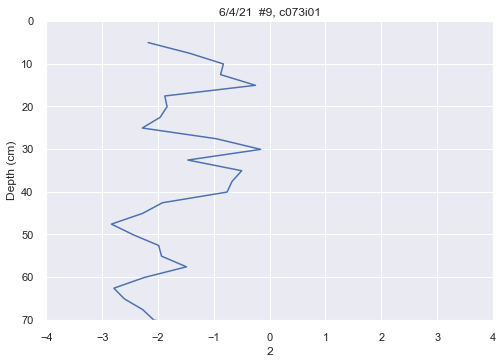

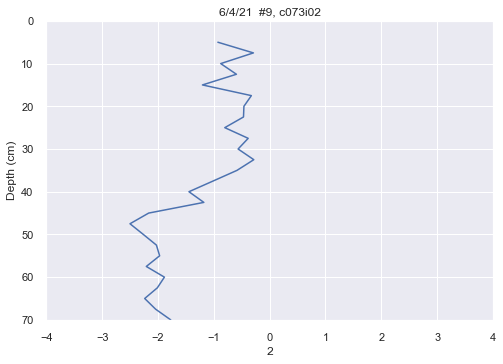

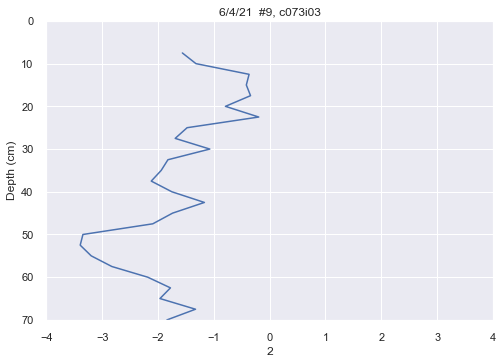

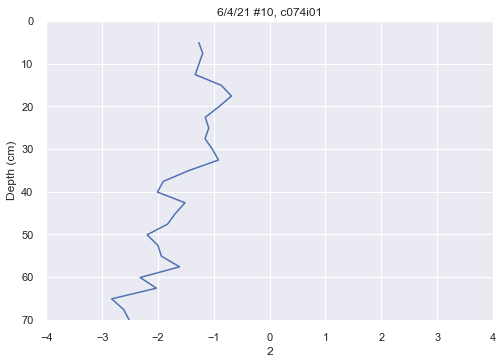

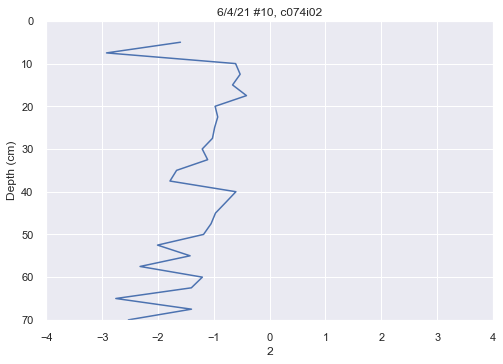

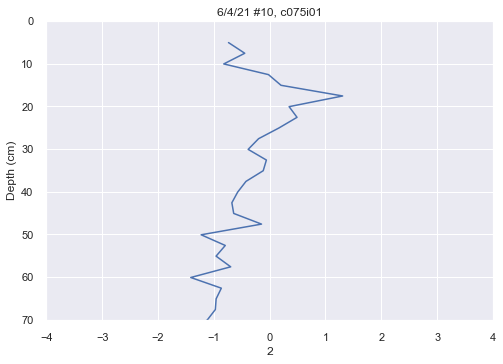

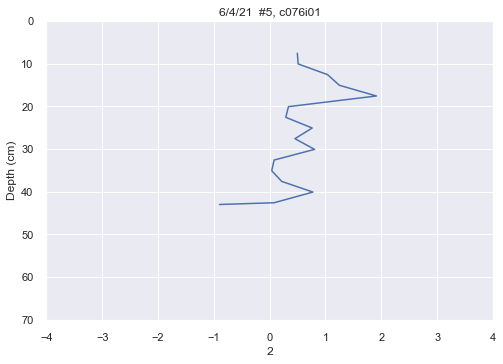

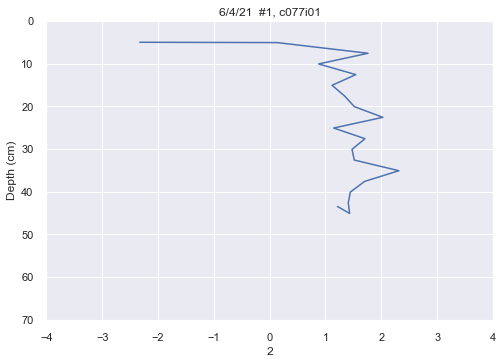

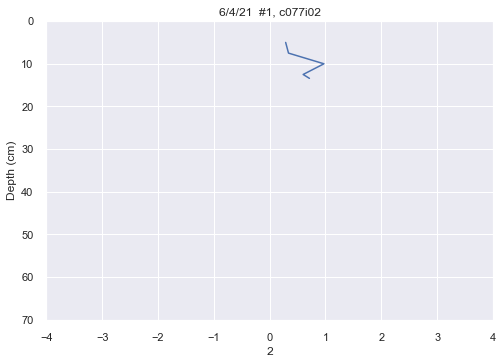

In [25]:
component = 2
for insertion in df_info['i_unique'].unique():
    insertion_df_info = df_info.loc[df_info['i_unique'] == insertion]
    insertion_components = X_pca_df.loc[df_info['i_unique'] == insertion]
    fig, ax = plt.subplots()
    ax.set_title(f"{insertion_df_info.iat[0, -3]}, {insertion}")
    ax.set_ylim(70, 0)
    ax.set_xlim(-4, 4)
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel(f"{component}")
    ax.plot(insertion_components.iloc[:, component], insertion_df_info['depth'])
    plt.show()
    plt.close()

In [41]:
mean_absorbance = df_use.groupby('stop').mean()

In [46]:
mean_mean_absorbance = mean_absorbance.iloc[:, :-3].mean(axis=1)

In [47]:
mean_mean_absorbance

stop
5/27/21  #1    0.549577
5/27/21  #2    0.516024
5/27/21  #3    0.543682
5/27/21  #4    0.569161
5/27/21  #5    0.590574
5/27/21  #6    0.637390
6/4/21  #1     0.572229
6/4/21  #2     0.612955
6/4/21  #3     0.727313
6/4/21  #4     0.584748
6/4/21  #5     0.580764
6/4/21  #6     0.520261
6/4/21  #7     0.551284
6/4/21  #8     0.619726
6/4/21  #9     0.654344
6/4/21 #10     0.674155
dtype: float64

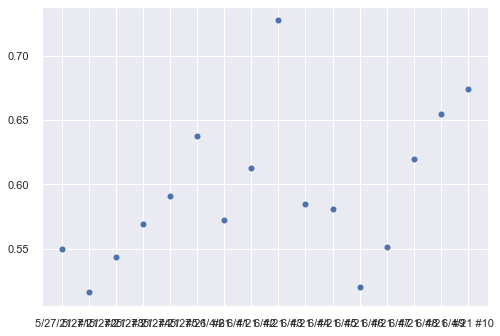

In [67]:
plt.plot(mean_mean_absorbance, 'o')

In [48]:
mean_X_pca = X_pca_df.groupby(df_use['stop']).mean()

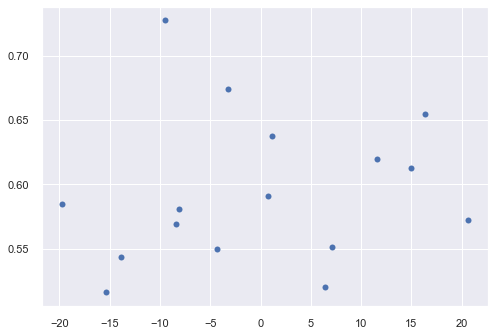

In [49]:
plt.plot(mean_X_pca[0], mean_mean_absorbance, 'o' )

In [51]:
df_use.iloc[:, :-8]

,533.4,534.8,536.2,537.7,539.1,540.5,541.9,543.4,544.8,546.2,...,835.0,836.2,837.4,838.7,839.9,841.1,842.3,843.5,844.7,845.9
2,0.550266,0.547796,0.563194,0.550510,0.549021,0.556036,0.533332,0.541878,0.533451,0.535555,...,0.401945,0.409963,0.404762,0.403786,0.399996,0.403702,0.403303,0.402973,0.402337,0.409881
3,0.553913,0.575164,0.567536,0.539224,0.559344,0.567863,0.563882,0.586287,0.554126,0.562368,...,0.424523,0.416682,0.415174,0.412768,0.412454,0.414864,0.416569,0.407689,0.416483,0.399619
4,0.686202,0.702606,0.670263,0.671369,0.690622,0.696210,0.682942,0.711097,0.694321,0.668574,...,0.465726,0.458915,0.453241,0.447985,0.460501,0.452828,0.455022,0.461921,0.454554,0.458807
5,0.631742,0.654073,0.648693,0.630098,0.616167,0.650735,0.620550,0.653872,0.624472,0.638912,...,0.444502,0.434112,0.443892,0.444352,0.438087,0.442618,0.445295,0.438711,0.439980,0.450573
6,0.721459,0.742745,0.703662,0.700518,0.717516,0.694641,0.685178,0.741355,0.697902,0.699171,...,0.509457,0.512354,0.506424,0.499361,0.498442,0.498158,0.499910,0.502380,0.492444,0.496678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0.699840,0.709474,0.723073,0.728634,0.733417,0.723443,0.697404,0.691037,0.731349,0.713582,...,0.483404,0.486455,0.489401,0.476159,0.475143,0.481971,0.479071,0.473218,0.471082,0.458113
1121,0.722083,0.708788,0.722387,0.694436,0.731891,0.728441,0.699109,0.728214,0.703620,0.718620,...,0.501169,0.499493,0.506607,0.489897,0.494935,0.494727,0.486645,0.475499,0.484531,0.490140
1122,0.735795,0.730332,0.724677,0.724574,0.763250,0.722616,0.724108,0.729617,0.753423,0.721890,...,0.496467,0.496569,0.491357,0.490322,0.494286,0.475696,0.485918,0.487966,0.491792,0.476648
1123,0.727268,0.709932,0.730223,0.749050,0.769614,0.713820,0.718912,0.722648,0.695937,0.719707,...,0.507279,0.507143,0.506970,0.497184,0.511758,0.507643,0.496432,0.500726,0.491565,0.513710


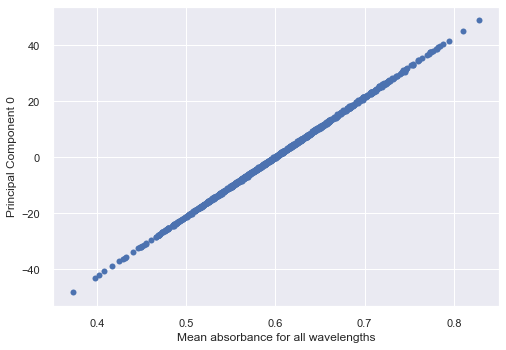

In [58]:
fig, ax = plt.subplots()
ax.set_xlabel("Mean absorbance for all wavelengths")
ax.set_ylabel("Principal Component 0")
plt.plot(df_use.iloc[:, :-8].mean(axis=1), X_pca_df[0], 'o');